In [35]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("BigDataProject").getOrCreate()

df = spark.read.csv("preprocessed_version.csv", header=True, inferSchema=True)

In [63]:
df.dtypes

[('FL_DATE', 'date'),
 ('OP_CARRIER', 'string'),
 ('OP_CARRIER_FL_NUM', 'int'),
 ('ORIGIN', 'string'),
 ('DEST', 'string'),
 ('CRS_DEP_TIME', 'double'),
 ('DEP_TIME', 'double'),
 ('DEP_DELAY', 'double'),
 ('TAXI_OUT', 'double'),
 ('WHEELS_OFF', 'double'),
 ('WHEELS_ON', 'double'),
 ('TAXI_IN', 'double'),
 ('CRS_ARR_TIME', 'double'),
 ('ARR_TIME', 'double'),
 ('ARR_DELAY', 'double'),
 ('CANCELLED', 'double'),
 ('CANCELLATION_CODE', 'string'),
 ('DIVERTED', 'double'),
 ('CRS_ELAPSED_TIME', 'double'),
 ('ACTUAL_ELAPSED_TIME', 'double'),
 ('AIR_TIME', 'double'),
 ('DISTANCE', 'double'),
 ('CARRIER_DELAY', 'double'),
 ('WEATHER_DELAY', 'double'),
 ('NAS_DELAY', 'double'),
 ('SECURITY_DELAY', 'double'),
 ('LATE_AIRCRAFT_DELAY', 'double'),
 ('YEAR', 'int'),
 ('MONTH', 'int'),
 ('DAY', 'int'),
 ('DAY_OF_WEEK', 'int'),
 ('DELAY_STATUS', 'string'),
 ('SEASON', 'string')]

In [37]:
from pyspark.sql import functions as F

df.select("AIR_TIME", "DISTANCE").describe().show()

+-------+------------------+-----------------+
|summary|          AIR_TIME|         DISTANCE|
+-------+------------------+-----------------+
|  count|          48928559|         48928559|
|   mean|105.33579617580808| 771.824385529114|
| stddev| 69.99522304826475|583.2128996412016|
|    min|              -1.0|             17.0|
|    max|             691.0|           4983.0|
+-------+------------------+-----------------+



In [38]:
from pyspark.sql.functions import  col

df.filter(col("CANCELLED") == 0.0).select("ARR_DELAY", "DEP_DELAY").describe().show()

+-------+------------------+-------------------+
|summary|         ARR_DELAY|          DEP_DELAY|
+-------+------------------+-------------------+
|  count|          47971360|           47971360|
|   mean|-7.630349149992829|-1.6632423804536707|
| stddev|10.197831847127791|  6.308423939689628|
|    min|             -36.0|              -21.0|
|    max|              23.0|               22.0|
+-------+------------------+-------------------+



In [39]:
# Count total and cancelled flights, and compute cancellation rate
total_flights = df.count()
cancelled_flights = df.filter("CANCELLED = 1.0").count()
cancellation_rate = 100 * cancelled_flights / total_flights
print(f"Cancelled Flights: {cancelled_flights} / {total_flights} ({cancellation_rate:.2f}%)")

Cancelled Flights: 957199 / 48928559 (1.96%)


/tmp/ipykernel_95/2359349023.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cancelled_pd, x="OP_CARRIER", y="cancelled_count", palette="mako")


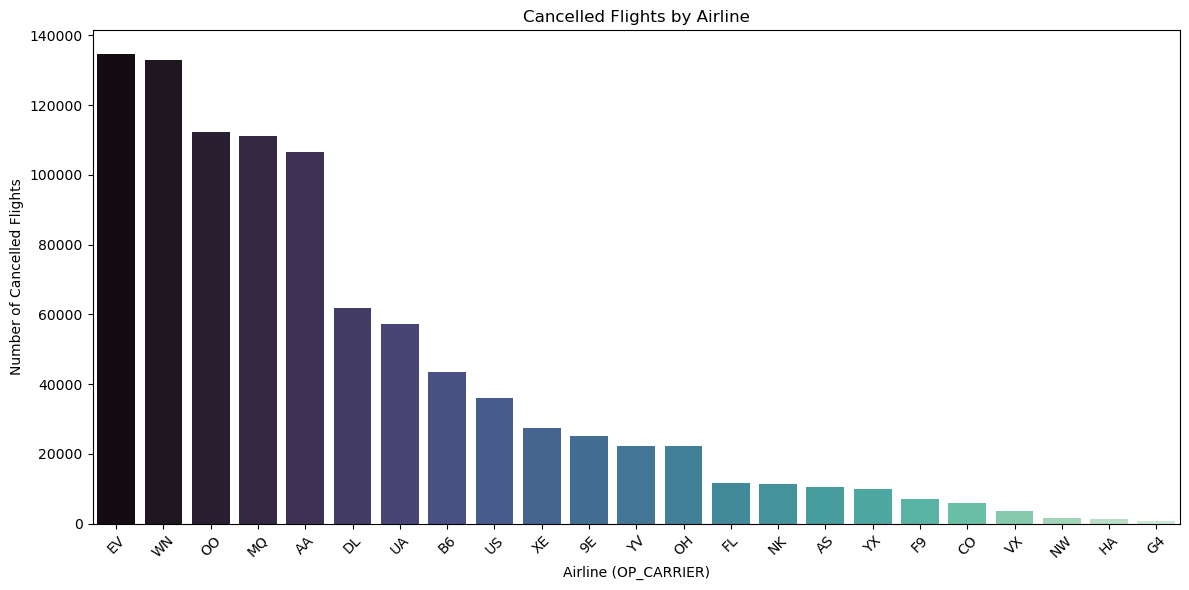

In [40]:
# ✈️ Aggregate cancelled flights per airline
cancelled_by_airline = df.filter("CANCELLED = 1.0") \
  .groupBy("OP_CARRIER") \
  .agg(F.count("*").alias("cancelled_count")) \
  .orderBy("cancelled_count", ascending=False)

cancelled_pd = cancelled_by_airline.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=cancelled_pd, x="OP_CARRIER", y="cancelled_count", palette="mako")

plt.title("Cancelled Flights by Airline")
plt.xlabel("Airline (OP_CARRIER)")
plt.ylabel("Number of Cancelled Flights")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_95/2527472863.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cancelled_airports_pd, x="ORIGIN", y="count", palette="flare")


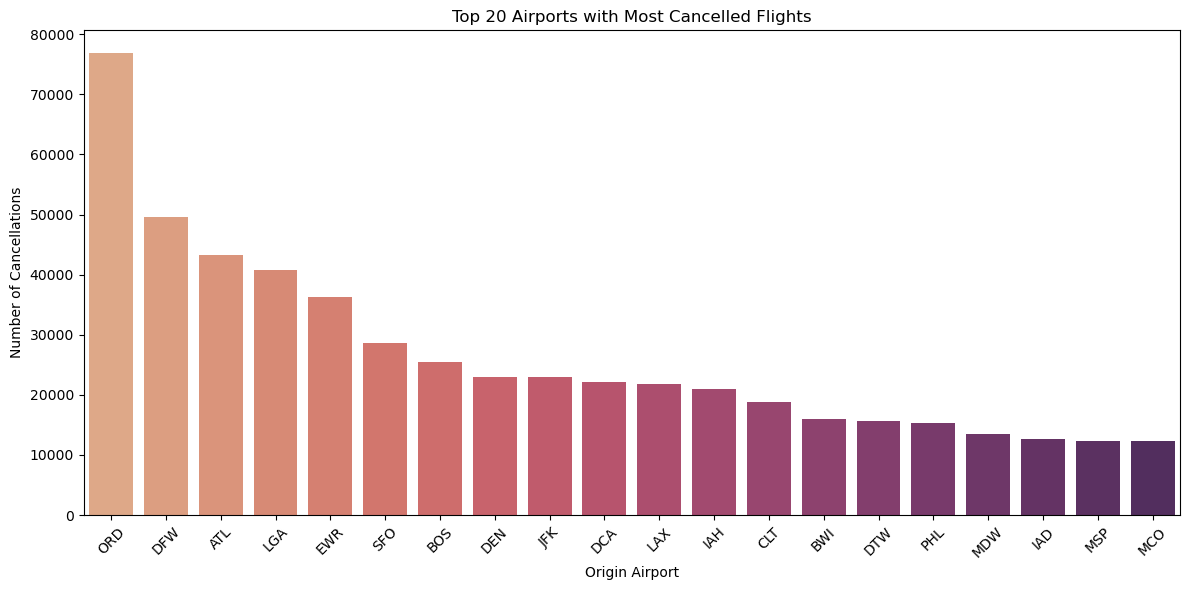

In [41]:
#  Group by ORIGIN and count cancelled flights
top_cancelled_airports = df.filter("CANCELLED = 1.0") \
  .groupBy("ORIGIN") \
  .count() \
  .orderBy("count", ascending=False) \
  .limit(20)  # Top 20 airports only (safe to visualize)

top_cancelled_airports_pd = top_cancelled_airports.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=top_cancelled_airports_pd, x="ORIGIN", y="count", palette="flare")

plt.title("Top 20 Airports with Most Cancelled Flights")
plt.xlabel("Origin Airport")
plt.ylabel("Number of Cancellations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

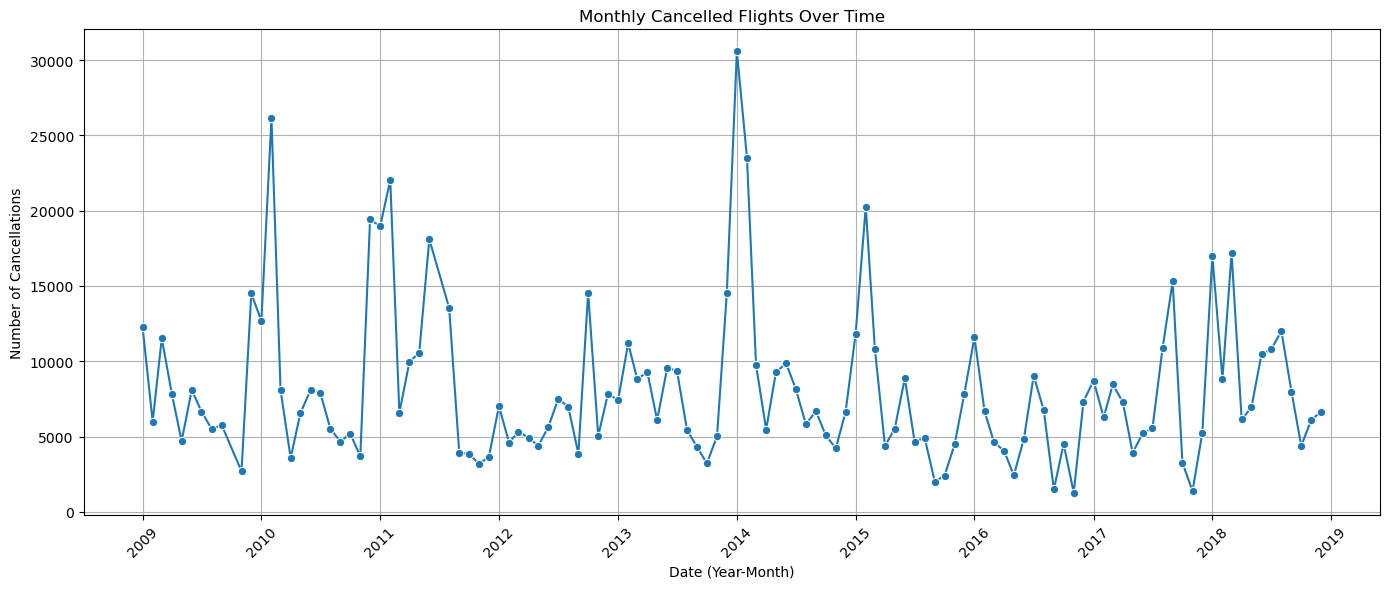

In [42]:
# 📆 Group cancelled flights by YEAR and MONTH
import pandas as pd
monthly_cancellations = df.filter("CANCELLED = 1.0") \
  .groupBy("YEAR", "MONTH") \
  .count() \
  .orderBy("YEAR", "MONTH")

monthly_cancellations_pd = monthly_cancellations.toPandas()

# 🧠 Combine YEAR and MONTH into a datetime column
monthly_cancellations_pd["date"] = pd.to_datetime(
    monthly_cancellations_pd["YEAR"].astype(str) + "-" + monthly_cancellations_pd["MONTH"].astype(str).str.zfill(2)
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_cancellations_pd, x="date", y="count", marker="o")

plt.title("Monthly Cancelled Flights Over Time")
plt.xlabel("Date (Year-Month)")
plt.ylabel("Number of Cancellations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [43]:
cancel_reasons = df.filter("CANCELLED = 1.0") \
  .groupBy("CANCELLATION_CODE") \
  .count() \
  .orderBy("count", ascending=False)

/tmp/ipykernel_95/1141517304.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cancel_reasons_pd, x="Reason", y="count", palette="Set2")


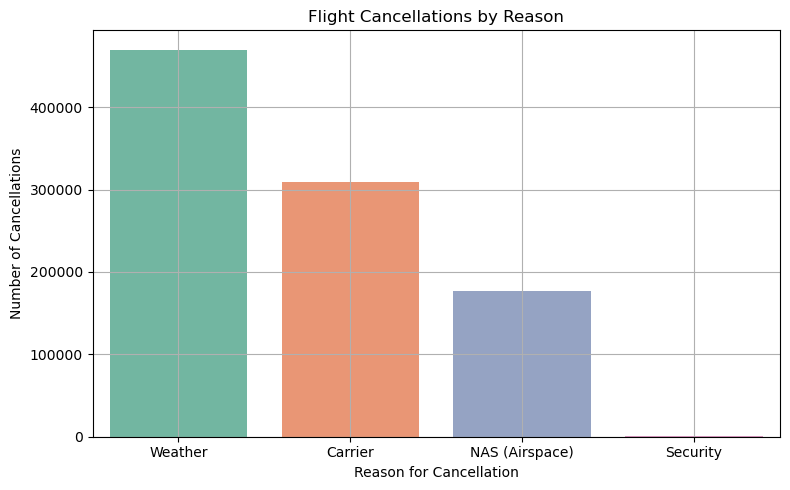

In [44]:
cancel_reasons_pd = cancel_reasons.toPandas()

# 📋 Mapping codes to readable labels
reason_labels = {
    "A": "Carrier",
    "B": "Weather",
    "C": "NAS (Airspace)",
    "D": "Security"
}

cancel_reasons_pd["Reason"] = cancel_reasons_pd["CANCELLATION_CODE"].map(reason_labels)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=cancel_reasons_pd, x="Reason", y="count", palette="Set2")

plt.title("Flight Cancellations by Reason")
plt.xlabel("Reason for Cancellation")
plt.ylabel("Number of Cancellations")
plt.tight_layout()
plt.grid(True)
plt.show()



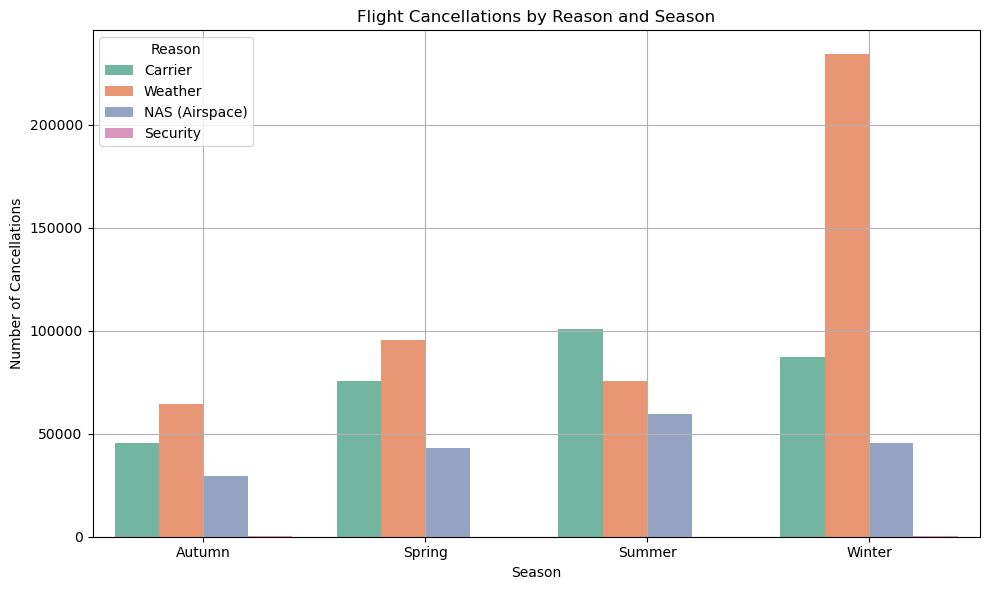

In [45]:
from pyspark.sql.functions import when, col

df = df.withColumn("SEASON", when(col("MONTH").isin(12, 1, 2), "Winter")
                             .when(col("MONTH").isin(3, 4, 5), "Spring")
                             .when(col("MONTH").isin(6, 7, 8), "Summer")
                             .otherwise("Autumn"))


seasonal_cancel = df.filter("CANCELLED = 1.0") \
  .groupBy("SEASON", "CANCELLATION_CODE") \
  .count() \
  .orderBy("SEASON", "CANCELLATION_CODE")

seasonal_cancel_pd = seasonal_cancel.toPandas()

# Map codes to labels for visualization
code_map = {"A": "Carrier", "B": "Weather", "C": "NAS (Airspace)", "D": "Security"}
seasonal_cancel_pd["Reason"] = seasonal_cancel_pd["CANCELLATION_CODE"].map(code_map)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=seasonal_cancel_pd, x="SEASON", y="count", hue="Reason", palette="Set2")

plt.title("Flight Cancellations by Reason and Season")
plt.ylabel("Number of Cancellations")
plt.xlabel("Season")
plt.tight_layout()
plt.grid(True)
plt.show()

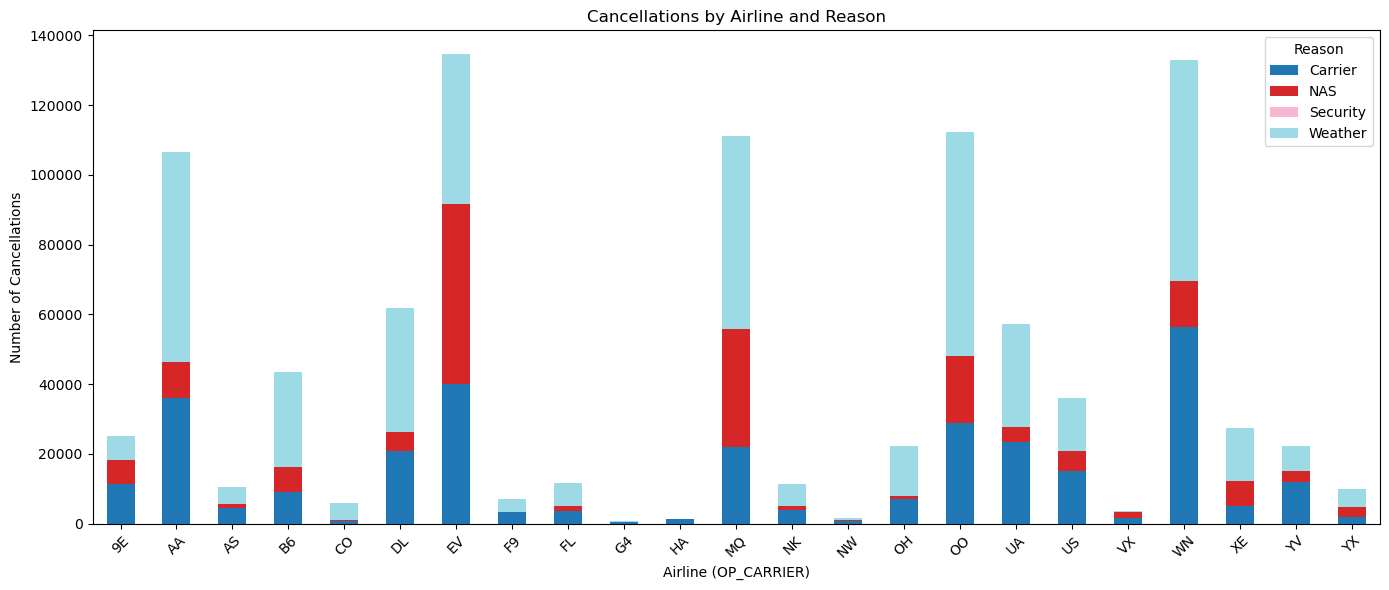

In [46]:
#✅ 1. Which airlines cancel most flights, and for what reasons?
# 🔍 Total number of cancellations per airline, broken down by reason code
airline_reason_cancel = df.filter("CANCELLED = 1.0") \
  .groupBy("OP_CARRIER", "CANCELLATION_CODE") \
  .count() \
  .orderBy("OP_CARRIER", "count", ascending=False)

airline_reason_cancel_pd = airline_reason_cancel.toPandas()

reason_labels = {
    "A": "Carrier",
    "B": "Weather",
    "C": "NAS",
    "D": "Security"
}
airline_reason_cancel_pd["Reason"] = airline_reason_cancel_pd["CANCELLATION_CODE"].map(reason_labels)

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot for stacked bar
pivot_df = airline_reason_cancel_pd.pivot(index="OP_CARRIER", columns="Reason", values="count").fillna(0)

pivot_df.plot(kind="bar", stacked=True, figsize=(14, 6), colormap="tab20")
plt.title("Cancellations by Airline and Reason")
plt.xlabel("Airline (OP_CARRIER)")
plt.ylabel("Number of Cancellations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


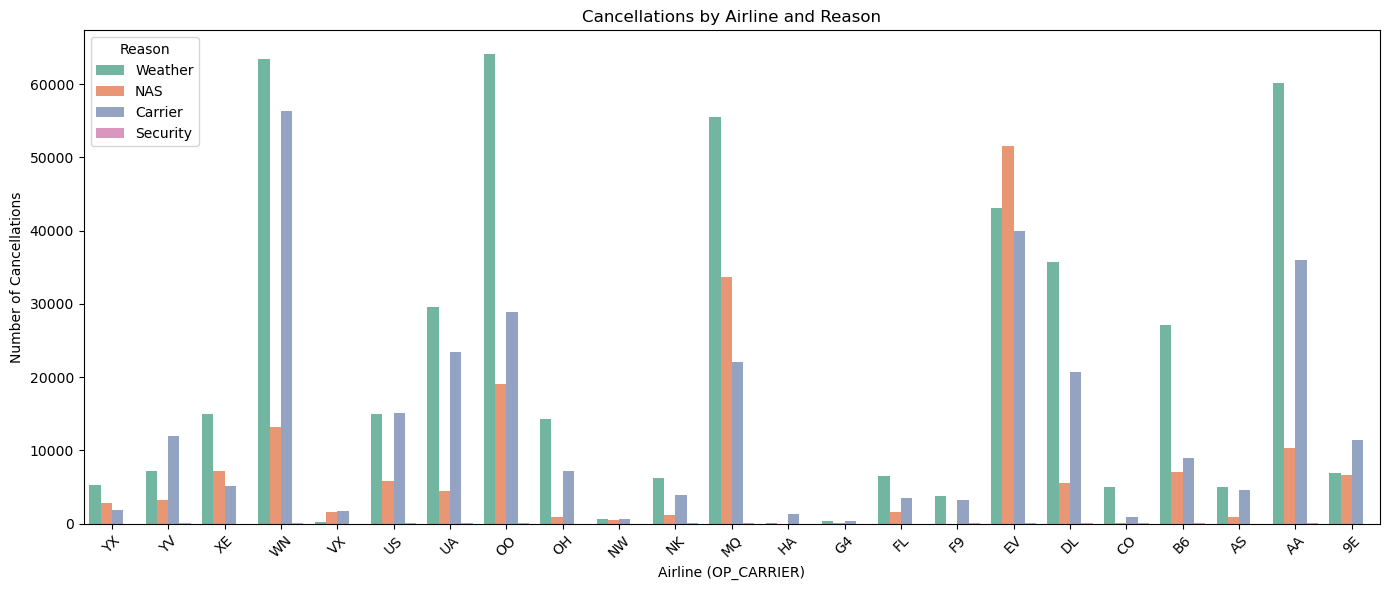

In [47]:
# ❓ Which airlines cancel the most flights, and for what reasons?

plt.figure(figsize=(14, 6))
sns.barplot(
    data=airline_reason_cancel_pd,
    x="OP_CARRIER", y="count", hue="Reason",
    palette="Set2"
)
plt.title("Cancellations by Airline and Reason")
plt.xlabel("Airline (OP_CARRIER)")
plt.ylabel("Number of Cancellations")
plt.xticks(rotation=45)
plt.legend(title="Reason")
plt.tight_layout()
plt.show()


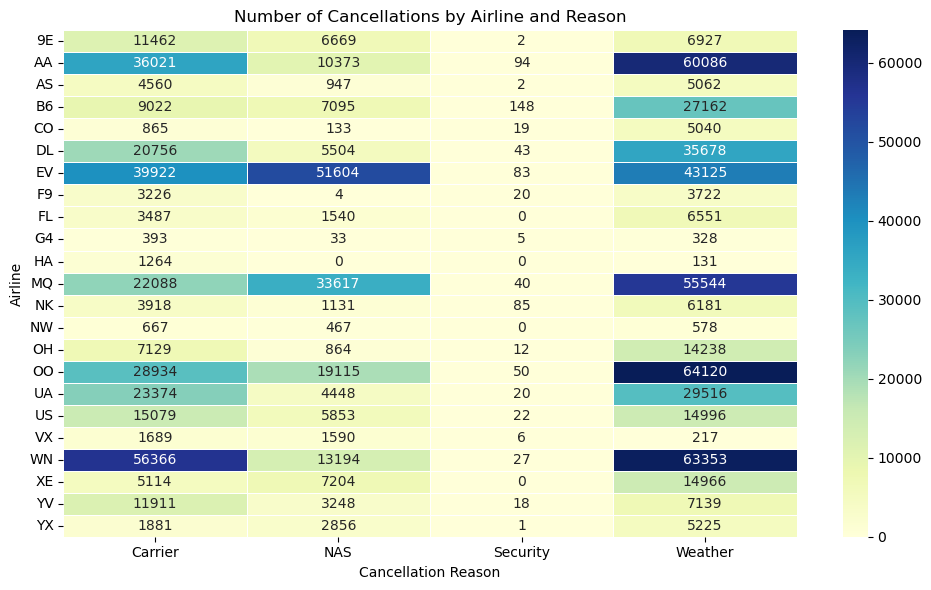

In [48]:
heatmap_data = airline_reason_cancel_pd.pivot(index="OP_CARRIER", columns="Reason", values="count").fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)

plt.title("Number of Cancellations by Airline and Reason")
plt.xlabel("Cancellation Reason")
plt.ylabel("Airline")
plt.tight_layout()
plt.show()


/tmp/ipykernel_95/1843381693.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


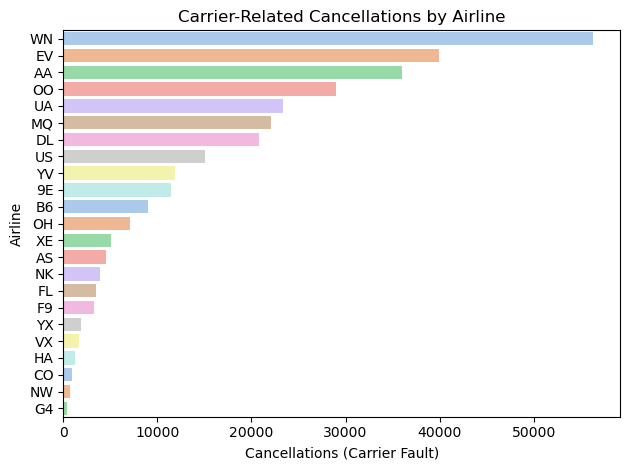

In [49]:
carrier_cancel = airline_reason_cancel_pd[airline_reason_cancel_pd["Reason"] == "Carrier"]

sns.barplot(
    data=carrier_cancel.sort_values("count", ascending=False),
    x="count", y="OP_CARRIER", palette="pastel"
)

plt.title("Carrier-Related Cancellations by Airline")
plt.xlabel("Cancellations (Carrier Fault)")
plt.ylabel("Airline")
plt.tight_layout()
plt.show()


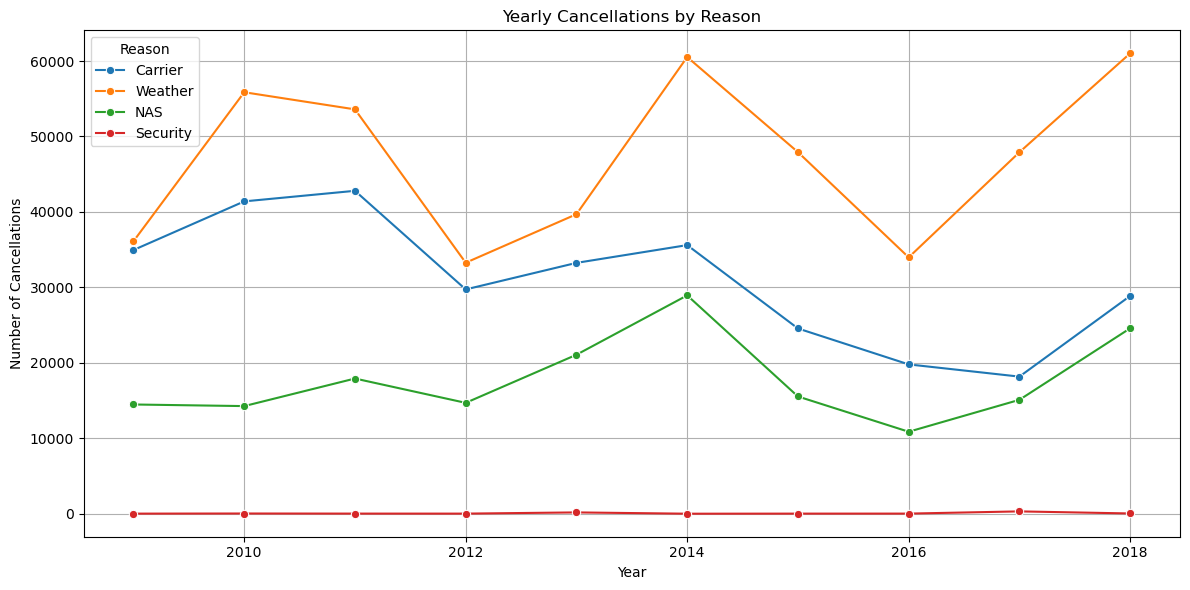

In [50]:
# ✅ 2. Has the frequency of each cancellation reason changed over the years?
# 🔍 Count of cancellations by reason per year
yearly_reason_cancel = df.filter("CANCELLED = 1.0") \
  .groupBy("YEAR", "CANCELLATION_CODE") \
  .count() \
  .orderBy("YEAR", "CANCELLATION_CODE")

yearly_reason_cancel_pd = yearly_reason_cancel.toPandas()
yearly_reason_cancel_pd["Reason"] = yearly_reason_cancel_pd["CANCELLATION_CODE"].map(reason_labels)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=yearly_reason_cancel_pd,
    x="YEAR", y="count", hue="Reason", marker="o", palette="tab10"
)

plt.title("Yearly Cancellations by Reason")
plt.xlabel("Year")
plt.ylabel("Number of Cancellations")
plt.grid(True)
plt.tight_layout()
plt.show()

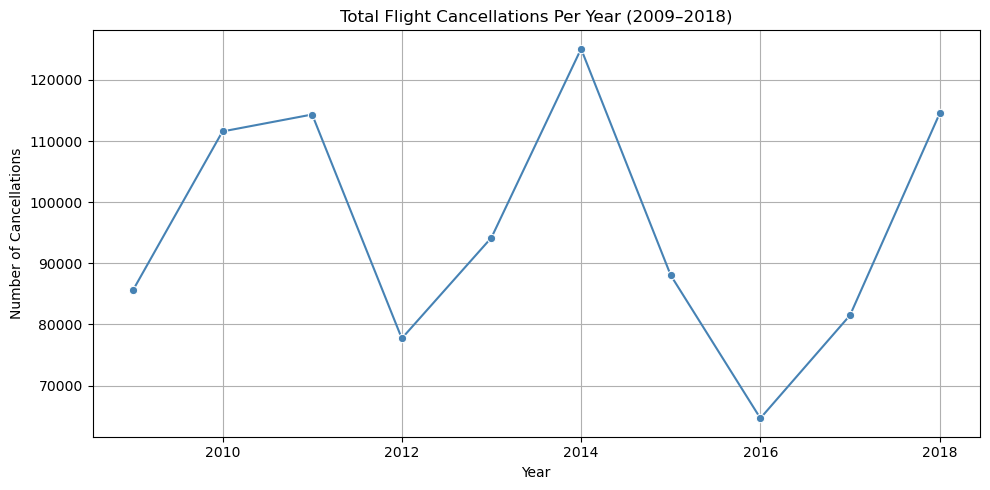

In [51]:
# Total cancellations by year
yearly_total = df.filter("CANCELLED = 1.0") \
  .groupBy("YEAR") \
  .count() \
  .orderBy("YEAR")

yearly_total_pd = yearly_total.toPandas()

# Plot total cancellations over time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_total_pd, x="YEAR", y="count", marker="o", color="steelblue")

plt.title("Total Flight Cancellations Per Year (2009–2018)")
plt.xlabel("Year")
plt.ylabel("Number of Cancellations")
plt.grid(True)
plt.tight_layout()
plt.show()



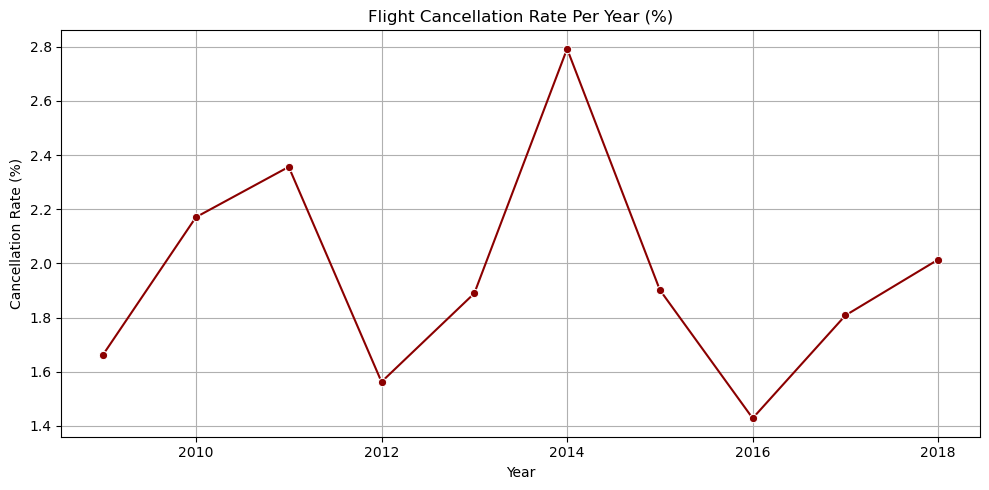

In [52]:
# Total flights per year
total_per_year = df.groupBy("YEAR").count().withColumnRenamed("count", "total_flights")

# Total cancellations per year
cancel_per_year = df.filter("CANCELLED = 1.0").groupBy("YEAR").count().withColumnRenamed("count", "cancelled")

# Join and calculate rate
rate_df = total_per_year.join(cancel_per_year, on="YEAR") \
    .withColumn("cancel_rate", (col("cancelled") / col("total_flights")) * 100)

rate_df_pd = rate_df.select("YEAR", "cancel_rate").orderBy("YEAR").toPandas()

# Plot rate
plt.figure(figsize=(10, 5))
sns.lineplot(data=rate_df_pd, x="YEAR", y="cancel_rate", marker="o", color="darkred")

plt.title("Flight Cancellation Rate Per Year (%)")
plt.xlabel("Year")
plt.ylabel("Cancellation Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()



+--------------------+--------+
|        DELAY_STATUS|   count|
+--------------------+--------+
|             On-Time|31287366|
|Delayed at Departure| 6064424|
|Delayed at Both Ends| 5393331|
|  Delayed at Arrival| 5226239|
|                None|  957199|
+--------------------+--------+



/tmp/ipykernel_95/3142088270.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delay_status_pd, x="DELAY_STATUS", y="count", palette="muted")


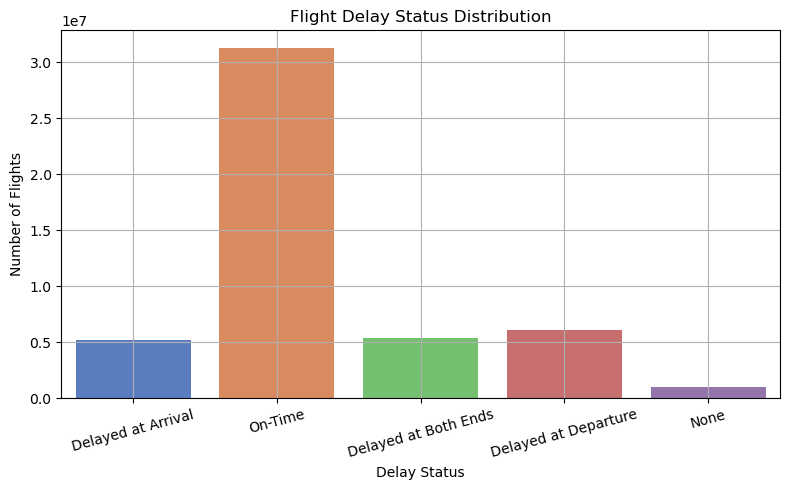

In [53]:
df.groupBy("DELAY_STATUS") \
  .count() \
  .orderBy("count", ascending=False) \
  .show()

delay_status_pd = df.groupBy("DELAY_STATUS").count().toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=delay_status_pd, x="DELAY_STATUS", y="count", palette="muted")

plt.title("Flight Delay Status Distribution")
plt.xlabel("Delay Status")
plt.ylabel("Number of Flights")
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(True)
plt.show()


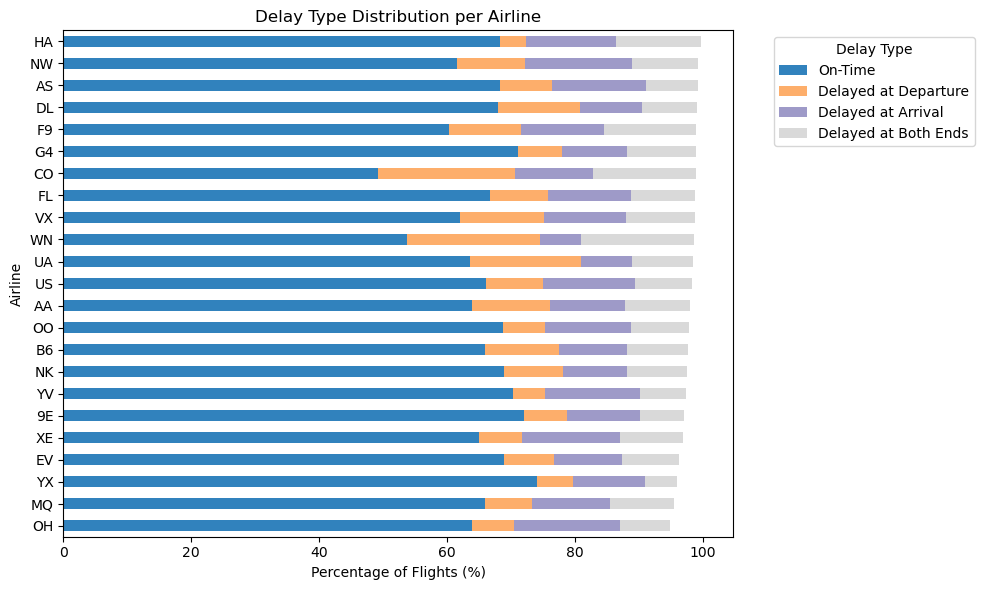

In [54]:
from pyspark.sql.functions import col, count, sum as Fsum, when, round

# Total flights per airline
total_flights = df.groupBy("OP_CARRIER").agg(count("*").alias("total"))

cancelled = df.groupBy("OP_CARRIER").agg(
    Fsum(when(col("CANCELLED") == 1.0, 1).otherwise(0)).alias("cancelled")
)

delay_status = df.groupBy("OP_CARRIER").pivot("DELAY_STATUS").count().na.fill(0)

# Combine all into one DataFrame
summary = total_flights \
    .join(cancelled, on="OP_CARRIER") \
    .join(delay_status, on="OP_CARRIER")

# Add cancellation rate
summary = summary.withColumn("cancel_rate", round((col("cancelled") / col("total")) * 100, 2))

summary_pd = summary.toPandas()

delay_cols = ["On-Time", "Delayed at Departure", "Delayed at Arrival", "Delayed at Both Ends"]

# Normalize for stacked bar (percentage)
for col_name in delay_cols:
    summary_pd[col_name] = (summary_pd[col_name] / summary_pd["total"] * 100).round(2)

summary_pd_sorted = summary_pd.sort_values("cancel_rate", ascending=False)

# Plot stacked bar chart of delay types
summary_pd_sorted.set_index("OP_CARRIER")[delay_cols].plot(
    kind="barh", stacked=True, figsize=(10, 6), colormap="tab20c"
)

plt.xlabel("Percentage of Flights (%)")
plt.ylabel("Airline")
plt.title("Delay Type Distribution per Airline")
plt.legend(title="Delay Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_95/3168335129.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_arr, x="avg_arr_delay", y="ORIGIN", palette="rocket")


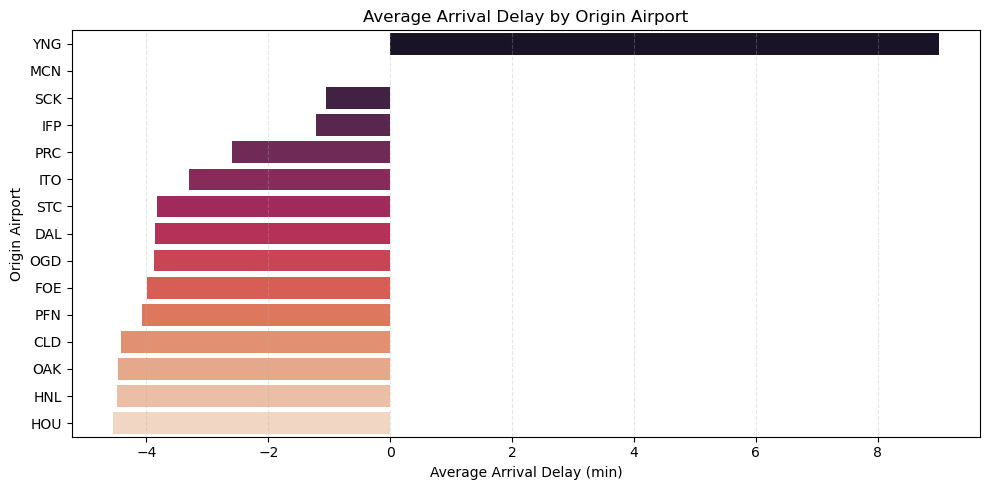

/tmp/ipykernel_95/3168335129.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_dep, x="avg_dep_delay", y="DEST", palette="mako")


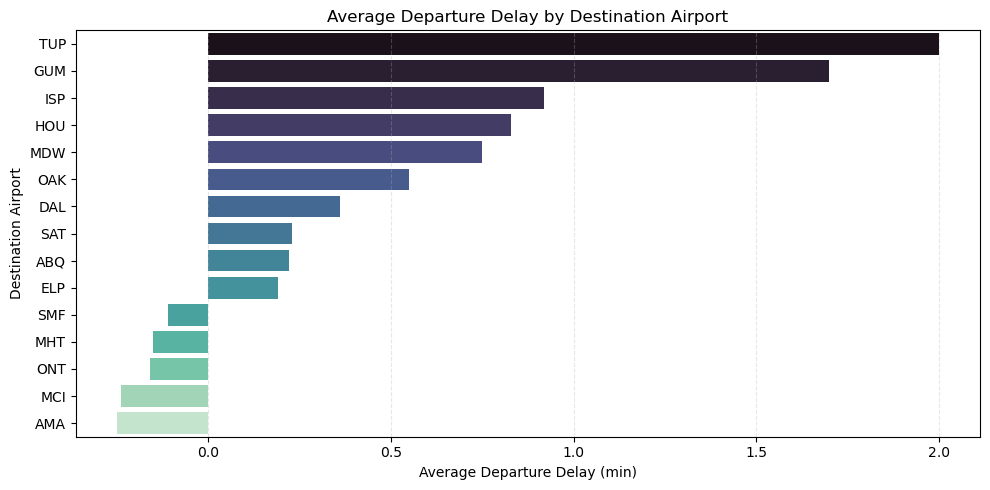

In [56]:
from pyspark.sql.functions import avg

avg_arr_delay_by_origin = df.filter(col("CANCELLED") == 0.0) \
    .groupBy("ORIGIN") \
    .agg(round(avg("ARR_DELAY"), 2).alias("avg_arr_delay")) \
    .orderBy("avg_arr_delay", ascending=False)

# Convert to pandas for plotting
arr_delay_pd = avg_arr_delay_by_origin.toPandas()

avg_dep_delay_by_dest = df.filter(col("CANCELLED") == 0.0) \
    .groupBy("DEST") \
    .agg(round(avg("DEP_DELAY"), 2).alias("avg_dep_delay")) \
    .orderBy("avg_dep_delay", ascending=False)

# Convert to pandas for plotting
dep_delay_pd = avg_dep_delay_by_dest.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

top_arr = arr_delay_pd.sort_values("avg_arr_delay", ascending=False).head(15)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_arr, x="avg_arr_delay", y="ORIGIN", palette="rocket")

plt.title("Average Arrival Delay by Origin Airport")
plt.xlabel("Average Arrival Delay (min)")
plt.ylabel("Origin Airport")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

top_dep = dep_delay_pd.sort_values("avg_dep_delay", ascending=False).head(15)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_dep, x="avg_dep_delay", y="DEST", palette="mako")

plt.title("Average Departure Delay by Destination Airport")
plt.xlabel("Average Departure Delay (min)")
plt.ylabel("Destination Airport")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



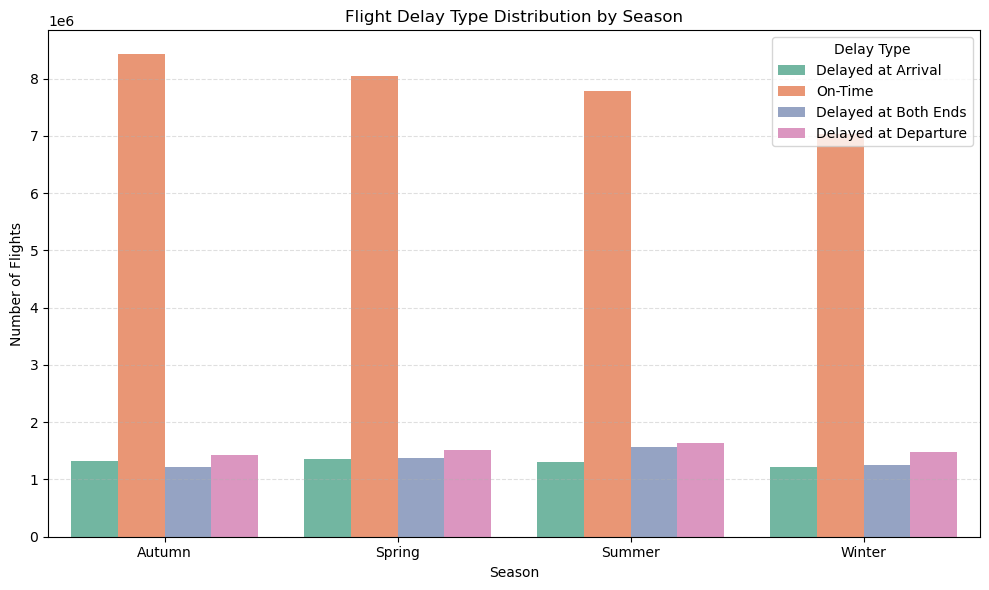

In [61]:
    season_delay = df.filter(col("CANCELLED") == 0.0) \
    .groupBy("SEASON", "DELAY_STATUS") \
    .count() \
    .orderBy("SEASON")

season_delay_pd = season_delay.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=season_delay_pd, x="SEASON", y="count", hue="DELAY_STATUS", palette="Set2")

plt.title("Flight Delay Type Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Number of Flights")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="Delay Type")
plt.tight_layout()
plt.show()

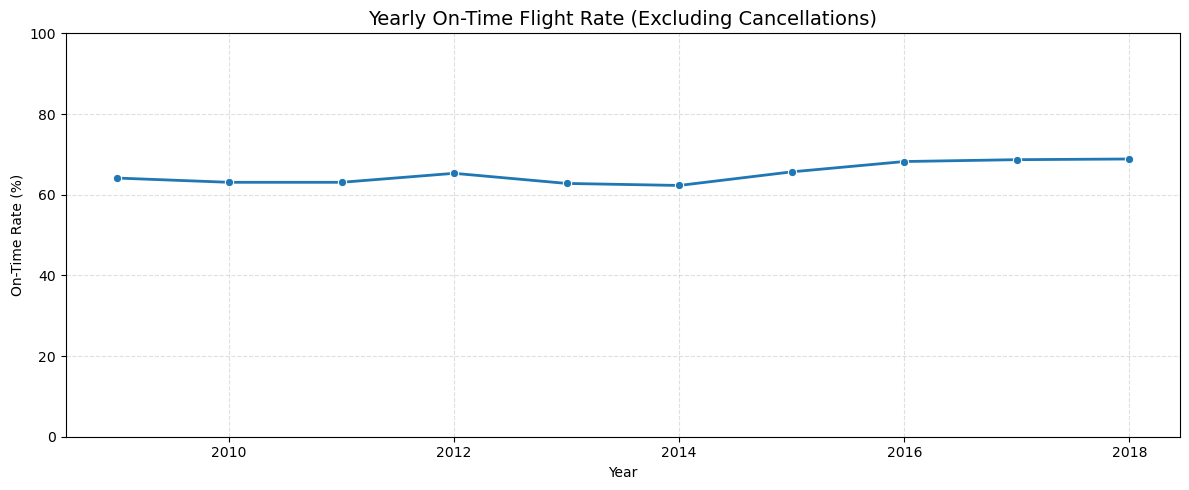

In [62]:
from pyspark.sql.functions import col, count, when, round

non_canceled_per_year = df.filter(col("CANCELLED") == 0.0) \
    .groupBy("YEAR") \
    .agg(count("*").alias("total_non_canceled"))

on_time_per_year = df.filter((col("CANCELLED") == 0.0) & (col("DELAY_STATUS") == "On-Time")) \
    .groupBy("YEAR") \
    .agg(count("*").alias("on_time_count"))

on_time_rate = on_time_per_year.join(non_canceled_per_year, on="YEAR") \
    .withColumn("on_time_rate", round(col("on_time_count") / col("total_non_canceled") * 100, 2)) \
    .orderBy("YEAR")

on_time_rate_pd = on_time_rate.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.lineplot(data=on_time_rate_pd, x="YEAR", y="on_time_rate", marker="o", linewidth=2)

plt.title("Yearly On-Time Flight Rate (Excluding Cancellations)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("On-Time Rate (%)")
plt.ylim(0, 100)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [60]:
# overall divertion rate
total_flights = df.count()
diverted_flights = df.filter(col("DIVERTED") == 1.0).count()
diversion_rate = 100 * diverted_flights / total_flights
print(f"Diversion Rate: {diverted_flights} / {total_flights} = {diversion_rate:.2f}%")


Diversion Rate: 267 / 48928559 = 0.00%
